# Neural network: first experiments with a linear model

## student 1: Ying LAI, student 2: Yingjie LIU

In this lab exercise we will code a neural network using numpy, without a neural network library.
Next week, the lab exercise will be to extend this program with hidden layers and activation functions.

The task is digit recognition: the neural network has to predict which digit in $\{0...9\}$ is written in the input picture. We will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a standard benchmark in machine learning.

The model is a simple linear  classifier $o = \operatorname{softmax}(Wx + b)$ where:
* $x$ is an input image that is represented as a column vector, each value being the "color" of a pixel
* $W$ and $b$ are the parameters of the classifier
* $\operatorname{softmax}$ transforms the output weight (logits) into probabilities
* $o$ is column vector that contains the probability of each category

We will train this model via stochastic gradient descent by minimizing the negative log-likelihood of the data:
$$
    \hat{W}, \hat{b} = \operatorname{argmin}_{W, b} \sum_{x, y} - \log p(y | x)
$$
Although this is a linear model, it classifies raw data without any manual feature extraction step.

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [3]:
!wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz -O mnist.pkl.gz

--2024-03-26 20:50:56--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
正在解析主机 github.com (github.com)... 140.82.121.3
正在连接 github.com (github.com)|140.82.121.3|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [跟随至新的 URL]
--2024-03-26 20:50:56--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：17051982 (16M) [application/octet-stream]
正在保存至: “mnist.pkl.gz”

mnist.pkl.gz        100%[===================>]  16.26M  22.0MB/s  用时 0.7s      

2024-03-26 20:50:58 (22.0 MB/s) - 已保存 “mnist.pkl.gz” [17051982/17051982])



In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

Each dataset is a list with two elemets:
* data[0] contains images
* data[1] contains labels

Data is stored as numpy.ndarray. You can use data[0][i] to retrieve image number i and data[1][i] to retrieve its label.

label: 3


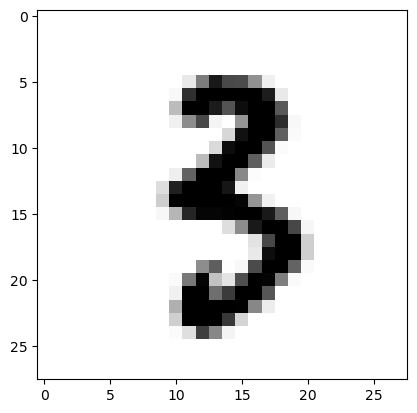

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

In [5]:
#显示一下数据集的构成 方便理解 show the srcture of dataset   #数据集和他的标签
train_data

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([6, 0, 0, ..., 7, 9, 8])]

**Question 1:** What are the characteristics of training data? (number of samples, dimension of input, number of labels)

The documentation of ndarray class is available here: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html

In [6]:
def getDimDataset(data):
    n_training = data[0].shape[0]
    n_feature = data[0].shape[1]
    n_label = len(np.unique(data[1]))
    # raise NotImplementedError('Implement the function')
    return n_training, n_feature, n_label

In [7]:
getDimDataset(train_data)

(50000, 784, 10)

# 1. Building functions

We now need to build functions that are required for the neural network.
$$
    o = \operatorname{softmax}(Wx + b) \\
    L(x, y) = -\log p(y | x) = -\log o[y]
$$

Note that in numpy, operator @ is used for matrix multiplication while * is used for element-wise multiplication.
The documentation for linear algebra in numpy is available here: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html

The first operation is the affine transformation $v = Wx + b$.
To compute the gradient, it is often convenient to write the forward pass as $v[i] = b[i] + \sum_j W[i, j] x[j]$.

In [8]:
W = np.random.randn(5,10)
x = np.random.randn(1,5)
print(W.transpose(1,0).shape)
np.matmul(W.transpose(1,0), x.transpose(1,0)) # 转置

(10, 5)


array([[-4.25801879],
       [-0.51341195],
       [ 0.30829108],
       [-0.04793931],
       [-2.91195036],
       [-2.02153797],
       [-0.54927267],
       [-0.55614338],
       [ 1.08235921],
       [-0.04459657]])

**Question 2:**  Complete the two functions `affine_transform` and `backward_affine_transform`. The last function compute the gradient the loss function according to weights of the linear module. The gradient of the loss according to output of the linear module is given as last parameter of the function backward_affine_transform.


In [9]:
# Input:
# - W: projection matrix
# - b: bias
# - x: input features
# Output:
# - vector
def affine_transform(W, b, x):
    return np.matmul(W, x) + b
    raise NotImplementedError('Implement the function')
# Input:
# - W: projection matrix
# - b: bias
# - x: input features
# - g: incoming gradient
# Output:
# - g_W: gradient wrt W
# - g_b: gradient wrt b
def backward_affine_transform(W, b, x, g):
    g_W = np.dot(g.reshape(len(g),1),x.reshape(1,len(x)))
    g_b = g
    # raise NotImplementedError('Implement the function')
    return g_W, g_b

In [10]:
W = np.asarray([[ 0.63024213,  0.53679375, -0.92079597],
 [-0.1155045,   0.62780356, -0.67961305],
 [ 0.08465286, -0.06561815, -0.39778322],
 [ 0.8242268,   0.58907262, -0.52208052],
 [-0.43894227, -0.56993247,  0.09520727]])


b = np.asarray([ 0.42706842,  0.69636598, -0.85611933, -0.08682553,  0.83160079])
x = np.asarray([-0.32809223, -0.54751413,  0.81949319])

o_gold = np.asarray([-0.82819732, -0.16640748, -1.17394705, -1.10761496,  1.36568213])
g = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])
g_W_gold = np.asarray([[ 0.02932773,  0.04894156, -0.07325341],
 [-0.14463576, -0.24136543,  0.36126434],
 [ 0.07417322,  0.12377887, -0.18526635],
 [ 0.31561399,  0.52669067, -0.78832562],
 [ 0.17529576,  0.29253025, -0.43784542]])
g_b_gold = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])


# quick test of the forward pass
o = affine_transform(W, b, x)
if o.shape != o_gold.shape:
    raise RuntimeError("Unexpected output dimension: got %s, expected %s" % (str(o.shape), str(o_gold.shape)))
if not np.allclose(o, o_gold):
    raise RuntimeError("Output of the affine_transform function is incorrect")
    
# quick test if the backward pass
g_W, g_b = backward_affine_transform(W, b, x, g)
if g_W.shape != g_W_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for W: got %s, expected %s" % (str(g_W.shape), str(g_W_gold.shape)))
if g_b.shape != g_b_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for b: got %s, expected %s" % (str(g_b.shape), str(g_b_gold.shape)))
if not np.allclose(g_W, g_W_gold):
    raise RuntimeError("Gradient of W is incorrect")
if not np.allclose(g_b, g_b_gold):
    raise RuntimeError("Gradient of b is incorrect")

The softmax function:
$$
     o = \operatorname{softmax}(w)
$$
where $w$ is a vector of logits in $\mathbb R$ and $o$ a vector of probabilities such that:
$$
    o[i] = \frac{\exp(w[i])}{\sum_j \exp(w[j])}
$$
We do not need to implement the backward for this experiment.

**Question 3** Implement the function softmax

In [11]:
# Input:
# - x: vector of logits
# Output
# - vector of probabilities
def softmax(x):
    b = np.max(x, axis=0, keepdims=True)
    e_x = np.exp(x - b)
    return e_x /np.sum(e_x, axis=0, keepdims=True)
    raise NotImplementedError('Implement the function')

**WARNING:** is your implementation numerically stable?

The $\exp$ function results in computations that overflows (i.e. results in numbers that cannot be represented with floating point numbers).
Therefore, it is always convenient to use the following trick to improve stability: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

In [12]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [1000000,1,100]
print(softmax(z))

[1. 0. 0.]


**Question 4**: From the result of the cell above, what can you say about the softmax output, even when it is stable?

In [13]:
# Just too simple test for the softmax function
x = np.asarray([0.92424884, -0.92381088, -0.74666024, -0.87705478, -0.54797015])
y_gold = np.asarray([0.57467369, 0.09053556, 0.10808233, 0.09486917, 0.13183925])

y = softmax(x)
if not np.allclose(y, y_gold):
    raise RuntimeError("Output of the softmax function is incorrect")
y

array([0.57467369, 0.09053556, 0.10808234, 0.09486917, 0.13183925])

Finally, we build the loss function and its gradient for training the network.

The loss function is the negative log-likelihood defined as:
$$
    \mathcal L(x, gold) = -\log \frac{\exp(x[gold])}{\sum_j \exp(x[j])} = -x[gold] + \log \sum_j \exp(x[j])
$$
This function is also called the cross-entropy loss (in Pytorch, different names are used dependending if the inputs are probabilities or raw logits).

Similarly to the softmax, we have to rely on the log-sum-exp trick to stabilize the computation: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

**Question 5:** Implement the forward and backward function for the negative loglikelihood

In [14]:
# Input:
# - x: vector of logits
# - gold: index of the gold class
# Output:
# - scalare equal to -log(softmax(x)[gold])
def nll(x, gold):
    return -x[gold]+np.log(sum(np.exp(x)))
    raise NotImplementedError('Implement the function')

# Input:
# - x: vector of logits
# - gold: index of the gold class
# - gradient (scalar)
# Output:
# - gradient wrt x
def backward_nll(x, gold, g):
    g_x = softmax(x)
    g_x[gold] -= 1
    g_x *= g
    # raise NotImplementedError('Implement the function')
    return g_x

In [16]:
# test
x = np.asarray([-0.13590009, -0.83649656,  0.03130881,  0.42559402,  0.08488182])
y_gold = 1.5695014420179738
g_gold = np.asarray([ 0.17609875,  0.08739591, -0.79185107,  0.30875221,  0.2196042 ])

y = nll(x, 2)
g = backward_nll(x, 2, 1.)


if not np.allclose(y, y_gold):
    raise RuntimeError("Output is incorrect")

if g.shape != g_gold.shape:
        raise RuntimeError("Unexpected gradient dimension: got %s, expected %s" % (str(g.shape), str(g_gold.shape)))
if not np.allclose(g, g_gold):
    raise RuntimeError("Gradient is incorrect")

In [17]:
y

1.5695014476527018

In [18]:
g

array([ 0.17609875,  0.08739591, -0.79185107,  0.30875221,  0.2196042 ])

The following code test the implementation of the gradient using finite-difference approximation, see: https://timvieira.github.io/blog/post/2017/04/21/how-to-test-gradient-implementations/

Your implementation should pass this test.

In [19]:
# this is python re-implementation of the test from the Dynet library
# https://github.com/clab/dynet/blob/master/dynet/grad-check.cc

def is_almost_equal(grad, computed_grad):
    #print(grad, computed_grad)
    f = abs(grad - computed_grad)
    m = max(abs(grad), abs(computed_grad))

    if f > 0.01 and m > 0.:
        f /= m

    if f > 0.01 or math.isnan(f):
        return False
    else:
        return True

def check_gradient(function, weights, true_grad, alpha = 1e-3):
    # because input can be of any dimension,
    # we build a view of the underlying data with the .shape(-1) method
    # then we can access any element of the tensor as a elements of a list
    # with a single dimension
    weights_view = weights.reshape(-1)
    true_grad_view = true_grad.reshape(-1)
    for i in range(weights_view.shape[0]):
        old = weights_view[i]

        weights_view[i] = old - alpha
        value_left = function(weights).reshape(-1)

        weights_view[i] = old + alpha
        value_right = function(weights).reshape(-1)

        weights_view[i] = old
        grad = (value_right - value_left) / (2. * alpha)

        if not is_almost_equal(grad, true_grad_view[i]):
            return False

        return True
    


In [20]:
# Test the affine transformation

x = np.random.uniform(-1, 1, (6,))
W = np.random.uniform(-1, 1, (3, 6))
b = np.random.uniform(-1, 1, (3,))

for i in range(3):
    y = affine_transform(W, b, x)
    g = np.zeros_like(y)
    g[i] = 1.
    g_W, _ = backward_affine_transform(W, b, x, g)
    print(check_gradient(lambda W: affine_transform(W, b, x)[i], W, g_W))

True
True
True


/var/folders/f5/jhrqh_cs6p72_tsw42gjd4cc0000gn/T/ipykernel_60972/199068466.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if f > 0.01 or math.isnan(f):


In [21]:
# Test the negative likelihood loss

x = np.random.uniform(-1, 1, (4,))

for gold in range(4):
    y = nll(x, gold)
    g = np.zeros_like(x)
    g_gold = backward_nll(x, gold, 1.)
    print(check_gradient(lambda x: nll(x, gold), x, g_gold))

True
True
True
True


/var/folders/f5/jhrqh_cs6p72_tsw42gjd4cc0000gn/T/ipykernel_60972/199068466.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if f > 0.01 or math.isnan(f):


# 2. Parameter initialization

We are now going to build the function that will be used to initialize the parameters of the neural network before training.
Note that for parameter initialization you must use **in-place** operations:

In [22]:
# create a random ndarray
a = np.random.uniform(-1, 1, (5,))

# this does not change the data of the ndarray created above!
# it creates a new ndarray and replace the reference stored in a
a = np.zeros((5, ))

# this will change the underlying data of the ndarray that a points to
a[:] = 0

# similarly, this creates a new array and change the object pointed by a
a = a + 1

# while this change the underlying data of a
a += 1

In [23]:
print(a)

[2. 2. 2. 2. 2.]


For an affine transformation, it is common to:
* initialize the bias to 0
* initialize the projection matrix with Glorot initialization (also known as Xavier initialization)

The formula for Glorot initialization can be found in equation 16 (page 5) of the original paper: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

**Question 6:** Fill the two initilization functions below

In [24]:
def zero_init(b):
    return np.zeros(b)
    raise NotImplementedError('Implement the function')

def glorot_init(W):
    dim_output, dim_input = W.shape
    limit = np.sqrt(6 / (dim_input + dim_output))
    return np.random.uniform(-limit, limit, (dim_output, dim_input))
    raise NotImplementedError('Implement the function')

# 3. Building and training the neural network

In our simple example, creating the neural network is simply instantiating the parameters $W$ and $b$.
They must be ndarray object with the correct dimensions.

**Question 7:** Fill the function that create and initialize the parameters

In [25]:
def create_parameters(dim_input, dim_output):
    W = np.zeros((dim_output, dim_input))
    W = glorot_init(W)
    b = zero_init(dim_output)
    
    return W, b

The recent success of deep learning is (partly) due to the ability to train very big neural networks.
However, researchers became interested in building small neural networks to improve computational efficiency and memory usage.
Therefore, we often want to compare neural networks by their number of parameters, i.e. the size of the memory required to store the parameters.

**Question 8:** Fill the function that  print the number of parameters of the linear model

In [26]:
def print_n_parameters(W, b):
    n = W.size + b.size
    print("Number of parameters: %i" % (n))

We can now create the neural network and print its number of parameters:

In [27]:
dim_input = len(train_data[0][0])
dim_output = len(np.unique(train_data[1]))
W, b = create_parameters(dim_input, dim_output)
print_n_parameters(W, b)

Number of parameters: 7850


Finally, the training loop!

The training loop should be structured as follows:
* we do **epochs** over the data, i.e. one epoch is one loop over the dataset
* at each epoch, we first loop over the data and update the network parameters with respect to the loss gradient
* at the end of each epoch, we evaluate the network on the dev dataset
* after all epochs are done, we evaluate our network on the test dataset and compare its performance with the performance on dev

During training, it is useful to print the following information:
* the mean loss over the epoch: it should be decreasing!
* the accuracy on the dev set: it should be increasing!
* the accuracy on the train set: it shoud be increasing!

If you observe a decreasing loss (+increasing accuracy on test data) but decreasing accuracy on dev data, your network is overfitting!

Once you have build **and tested** this a simple training loop, you should introduce the following improvements:
* instead of evaluating on dev after each loop on the training data, you can also evaluate on dev n times per epoch
* shuffle the data before each epoch
* instead of memorizing the parameters of the last epoch only, you should have a copy of the parameters that produced the best value on dev data during training and evaluate on test with those instead of the parameters after the last epoch
* learning rate decay: if you do not observe improvement on dev, you can try to reduce the step size

After you conducted (successful?) experiments, you should write a report with results (in the notebook).

In [28]:
# before training, we initialize the parameters of the network
# zero_init(b)
# glorot_init(W)

n_epochs = 20 # number of epochs
step = 0.01 # step size for gradient updates

losses = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)

for epoch in range(n_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    # TODO
    for i in range(len(train_data[0])):
        x = train_data[0][i]
        gold = train_data[1][i]
        
        # forward
        y = affine_transform(W, b, x)
        loss = nll(y, gold)
        epoch_loss += loss

        # check if the prediction is correct
        if np.argmax(y) == gold:
            epoch_accuracy += 1
            accuracy[epoch] += 1
        
        # backward
        g = backward_nll(y, gold, 1.)
        g_W, g_b = backward_affine_transform(W, b, x, g)
        
        # gradient update
        W -= step * g_W
        b -= step * g_b

   
    losses[epoch] = epoch_loss / len(train_data[0])
    accuracy[epoch] /= len(train_data[0])

    dev_loss = 0
    dev_accuracy = 0
    for i in range(len(dev_data[0])):
        x = dev_data[0][i]
        gold = dev_data[1][i]
    
        y = affine_transform(W, b, x)
        loss = nll(y, gold)
        dev_loss += loss
    
        if np.argmax(y) == gold:
            dev_accuracy += 1
        
    dev_loss /= len(dev_data[0])
    dev_accuracy /= len(dev_data[0])

    print("Epoch %i: loss = %f, accuracy = %f, dev_loss = %f, dev_accuracy = %f" % (epoch, losses[epoch], accuracy[epoch], dev_loss, dev_accuracy))

# Test evaluation
# TODO
test_loss = 0
test_accuracy = 0
for i in range(len(test_data[0])):
    x = test_data[0][i]
    gold = test_data[1][i]

    y = affine_transform(W, b, x)
    loss = nll(y, gold)
    test_loss += loss

    if np.argmax(y) == gold:
        test_accuracy += 1

test_loss /= len(test_data[0])
test_accuracy /= len(test_data[0])

print("Test: loss = %f, accuracy = %f" % (test_loss, test_accuracy))


Epoch 0: loss = 0.377546, accuracy = 0.892740, dev_loss = 0.290028, dev_accuracy = 0.917000
Epoch 1: loss = 0.310318, accuracy = 0.912540, dev_loss = 0.279069, dev_accuracy = 0.922200
Epoch 2: loss = 0.297887, accuracy = 0.915680, dev_loss = 0.275319, dev_accuracy = 0.924200
Epoch 3: loss = 0.290829, accuracy = 0.918220, dev_loss = 0.273491, dev_accuracy = 0.925200
Epoch 4: loss = 0.285963, accuracy = 0.919720, dev_loss = 0.272447, dev_accuracy = 0.925500
Epoch 5: loss = 0.282272, accuracy = 0.920820, dev_loss = 0.271819, dev_accuracy = 0.925600
Epoch 6: loss = 0.279312, accuracy = 0.921760, dev_loss = 0.271450, dev_accuracy = 0.926400
Epoch 7: loss = 0.276850, accuracy = 0.922600, dev_loss = 0.271257, dev_accuracy = 0.926600
Epoch 8: loss = 0.274749, accuracy = 0.923120, dev_loss = 0.271192, dev_accuracy = 0.926500
Epoch 9: loss = 0.272922, accuracy = 0.923800, dev_loss = 0.271221, dev_accuracy = 0.926800
Epoch 10: loss = 0.271311, accuracy = 0.924140, dev_loss = 0.271323, dev_accurac